In [1]:
%%file mu_CRRA.m
function mu = mu_CRRA(cons, gamma)
% Function mu_CRRA
%  marginal_utility = mu_CRRA( consumption, gamma )
%
% Purpose:
%  Compute marginal utility of CRRA-type function
%
%  Record of revisions:
%     Date     Programmer  Description of change
%  ==========  ==========  =====================
%  02/22/2016  T. Yamada   Original code

mu = cons.^-gamma;

return

Created file 'c:\Users\takek\Dropbox\projects\Shared\Textbook Project\Codes\quant-macro-book\chapter4\Matlab\1_TI_Optimization\mu_CRRA.m'.


In [5]:
%%file EulerEq.m
function res = EulerEq(cons,capital,cfcn)
% オイラー方程式に代入した際の残差を返す関数

global beta gamma alpha delta kgrid

wealth = capital.^alpha + (1.-delta).*capital;

kprime = wealth - cons;
% トリック: k'は正の値しか取らない
kprime = max(kgrid(1),kprime);

% 次期の政策関数を線形補間
cnext = interp1(kgrid,cfcn,kprime,'linear','extrap');
% 次期の価値関数をスプライン補間
%cnext = interp1(kgrid,cfcn,kprime,'spline');

% オイラー方程式の残差を求める（u'(c)をmu_CRRA関数を用いて計算している）
res = mu_CRRA(cons,gamma) - beta*mu_CRRA(cnext,gamma)*(alpha*kprime.^(alpha-1) + (1.-delta));
 
return

Created file 'c:\Users\takek\Dropbox\projects\Shared\Textbook Project\Codes\quant-macro-book\chapter4\Matlab\1_TI_Optimization\EulerEq.m'.


In [3]:
% MATLABではグローバル変数を使って関数への変数受け渡しを行う
% Julia, Pythondではコンストラクタを用いる
global beta gamma alpha delta kgrid

% カリブレーション
beta  = 0.96; % 割引因子
gamma = 1.0;  % 相対的危険回避度(異時点間の代替の弾力性の逆数)
alpha = 0.40; % 資本分配率
delta = 1.00; % 固定資本減耗(delta=1.0のときは解析解が存在)

% 定常状態の値
ykss = (1/beta-1+delta)/alpha;
kss = ykss^(1/(alpha-1));
yss = ykss*kss;
css = yss-delta*kss;

kmax = 0.5;   % 資本グリッドの最大値
kmin = 0.05;  % 資本グリッドの最小値 (0にすると生産が出来なくなる)

%% STEP 1(a): グリッド生成
nk   = 21;    % グリッドの数
kgrid = linspace(kmin, kmax, nk)';

maxiter = 1000; % 繰り返し計算の最大値
tol  = 1.0e-5;  % 許容誤差(STEP 2)

In [8]:
% *** 収束の基準 ***
it = 1;          % ループ・カウンター
dif2 = 1.0;      % 政策関数の繰り返し誤差
%options.TolFun = 1.0e-10; % fsolveのオプション(最適化の許容誤差)

tic;
options = optimoptions('fsolve','Display','none'); % fsolveのオプション(最適化の結果を非表示にする)

disp(' ')
disp('-+- Solve a neoclassical growth model with time iteration -+-');
disp(' ')

%% STEP 1(b): 政策関数の初期値を当て推量
% 政策関数の初期化
cfcn0 = kgrid;
cfcn1 = zeros(nk,1);

% 繰り返し誤差を保存する変数を設定 
dif = zeros(2,maxiter);

%% STEP 4: 政策関数を繰り返し計算
while (it < maxiter && dif2 > tol)

    for i = 1:nk

        capital = kgrid(i);
        wealth = capital.^alpha + (1.-delta).*capital;

        % MATLABの最適化関数(fsolve)を使って各グリッド上の政策関数の値を探す
        % 最適化の初期値は古い政策関数の値
        cons = fsolve(@EulerEq,cfcn0(i,1),options,capital,cfcn0);
        cfcn1(i,1) = cons;
        kprime = wealth-cons;
        % グリッドごとに最適化の結果を確認
        %disp([cons capital wealth kprime]);
        %pause

    end

    % 繰り返し計算誤差を確認
    dif2 = max(abs(cfcn1-cfcn0));

    % 収束途中の繰り返し計算誤差を保存
    dif(2,it) = dif2;

    % 政策関数をアップデート
    cfcn0 = cfcn1;

    fprintf('iteration index: %i \n', it);
    fprintf('policy function iteration error: %1.6f \n', dif2);

    it = it + 1;

end

disp(' ');
toc;

 
-+- Solve a neoclassical growth model with time iteration -+-
 
iteration index: 1 
policy function iteration error: 0.098231 
iteration index: 2 
policy function iteration error: 0.031637 
iteration index: 3 
policy function iteration error: 0.011354 
iteration index: 4 
policy function iteration error: 0.005518 
iteration index: 5 
policy function iteration error: 0.002319 
iteration index: 6 
policy function iteration error: 0.000923 
iteration index: 7 
policy function iteration error: 0.000362 
iteration index: 8 
policy function iteration error: 0.000140 
iteration index: 9 
policy function iteration error: 0.000053 
iteration index: 10 
policy function iteration error: 0.000020 
iteration index: 11 
policy function iteration error: 0.000008 
 
経過時間は 0.367582 秒です。



In [9]:
%% 最終的な政策関数が得られてから貯蓄関数を計算
pfcn0 = kgrid.^alpha + (1-delta)*kgrid - cfcn0;

%% 解析的解
p_true = beta*alpha*(kgrid.^alpha);

%% オイラー方程式から誤差を測定
% 元のグリッドではオイラー方程式の誤差はゼロになるため、グリッドを細かくとる
kgrid_err = linspace(kmin, kmax, (nk-1)*10+1)';
% c=h(k;b)の値を線形補間
cons = interp1(kgrid,cfcn0(:,1),kgrid_err);
LHS  = mu_CRRA(cons, gamma);

% k'=f(k)-c
kp   = kgrid_err.^alpha + (1-delta)*kgrid_err - cons;
% c'=h(k';b)の値を線形補間
cnext = interp1(kgrid, cfcn0(:,1), kp);
rent = alpha.*kp.^(alpha-1.0) - delta;
RHS  = beta.*(1.+rent).*mu_CRRA(cnext,gamma);

err  = RHS./LHS-1.0;

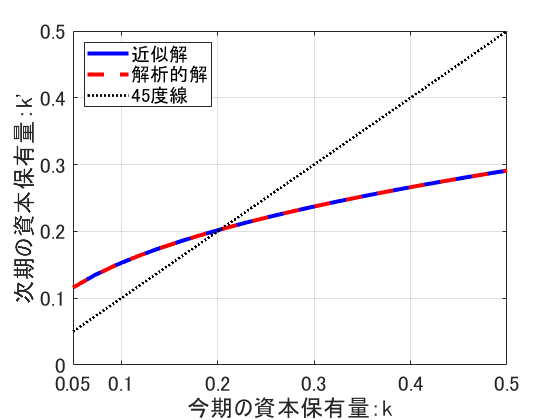

In [12]:
%%
figure;
plot(kgrid, pfcn0, '-', 'Color', 'blue', 'LineWidth', 3);
hold on;
plot(kgrid, p_true, '--', 'Color', 'red', 'LineWidth', 3);
plot(kgrid, kgrid, ':', 'Color', 'black', 'LineWidth', 2);
xlabel('今期の資本保有量：k', 'FontSize', 16);
ylabel("次期の資本保有量：k'", 'FontSize', 16);
xlim([kmin kmax]);
xticks([0.05 0.1 0.2 0.3 0.4 0.5]);
xticklabels([0.05 0.1 0.2 0.3 0.4 0.5]);
legend('近似解', '解析的解', '45度線', 'Location', 'NorthWest');
grid on;
set(gca,'FontSize', 16);
saveas(gcf,'Fig_pti2.eps','epsc2');

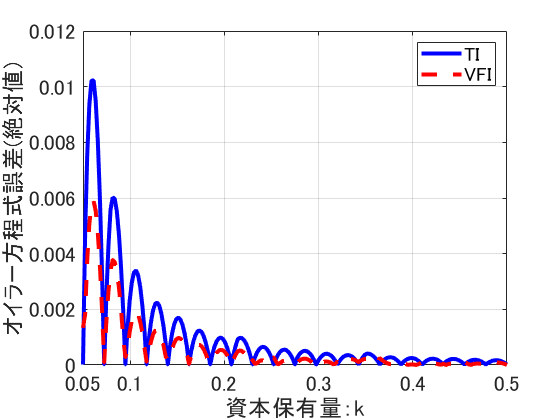

In [14]:
err2 = csvread("err_ndp.csv");
figure;
plot(kgrid_err, abs(err), '-', 'Color', 'blue', 'LineWidth', 3);
hold on;
plot(kgrid_err, abs(err2), '--', 'Color', 'red', 'LineWidth', 3);
xlabel('資本保有量：k', 'FontSize', 16);
ylabel('オイラー方程式誤差(絶対値)', 'FontSize', 16);
xlim([kmin kmax]);
xticks([0.05 0.1 0.2 0.3 0.4 0.5]);
xticklabels([0.05 0.1 0.2 0.3 0.4 0.5]);
legend('TI', 'VFI', 'Location', 'NorthEast');
grid on;
set(gca,'FontSize', 16);
saveas (gcf,'Fig_pti6.eps','epsc2');